In [1]:
import sys
workPath = '/home/jovyan/workspace'
if not workPath in sys.path:
    sys.path.append(workPath)

In [2]:
import planetengine
outputPath = planetengine.paths.make_testdir()

In [3]:
system = planetengine.tests.testsystems.get_system()

Fitted 1 variables to the figure.


Variable_varName=temperatureField{}



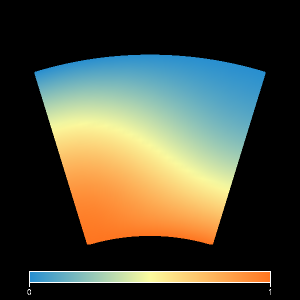

Variable_varName=temperatureField{}



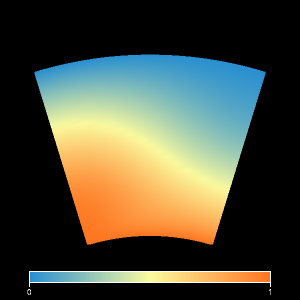

Variable_varName=temperatureField{}



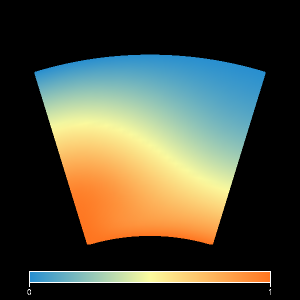

Variable_varName=temperatureField{}



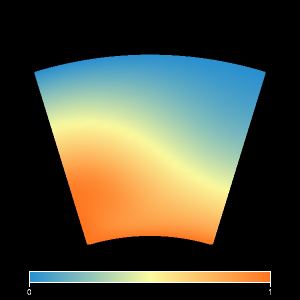

Variable_varName=temperatureField{}



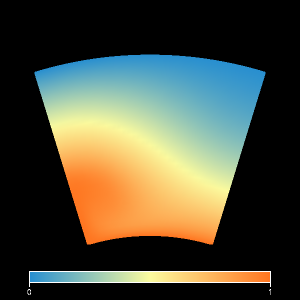

Variable_varName=temperatureField{}



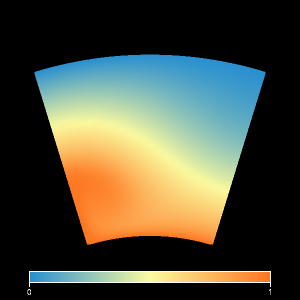

Variable_varName=temperatureField{}



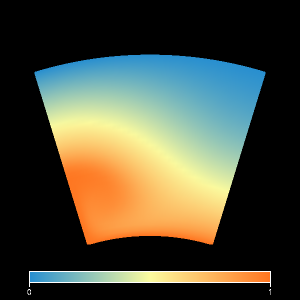

Variable_varName=temperatureField{}



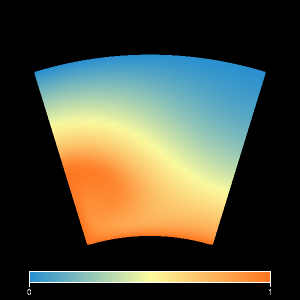

Variable_varName=temperatureField{}



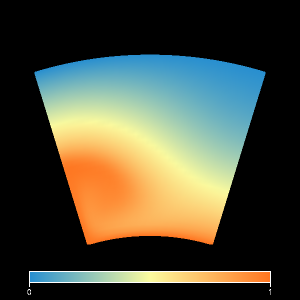

Variable_varName=temperatureField{}



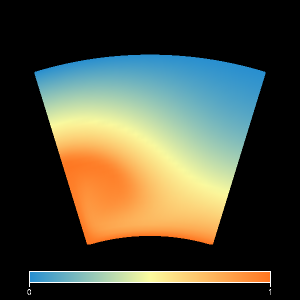

In [5]:
for i in range(10):
    system.go(10)
    system.show()

In [ ]:
    def __init__(
            self,
            args, # subBuilts (as Builts)
            kwargs, # subBuilts (as modules)
            inputs,
            script
            ):

In [ ]:
import planetengine

class Observer(planetengine._built.Built):

    script = 'test' # __file__

    def __init__(
            self,
            _prompt
            ):

        self._prompt = _prompt

    def prompt(self):
        self._prompt()

In [ ]:
import planetengine

def build(*args, name = None, **kwargs):
    built = Standard(*args, **kwargs)
    if type(name) == str:
        built.name = name
    return built

class Standard(
        self,
        obsVars,
        
        )

In [ ]:
import underworld as uw
from underworld import function as fn
import math
import time
import glucifer
import numpy as np
import math

from . import utilities
from . import analysis
from . import visualisation
from .utilities import Grouper

def build():

    ## HOUSEKEEPING: IMPORTANT! ###

    inputs = locals().copy()
    script = __file__
    name = 'standard'
#     hashID = utilities.hashstamp(script, inputs)

    def attach(system):

        step = system.step
        modeltime = system.modeltime
        if hasattr(system, 'obsVars'):
            obsVars = [
                *sorted(system.varsOfState.items()),
                *[varTuple for varTuple in sorted(system.obsVars.items()) \
                    if not varTuple in system.varsOfState.items()]
                ]
        else:
            obsVars = sorted(system.varsOfState.items())

        ### MAKE STATS ###

        statsDict = {}
        formatDict = {}

        for varName, var in obsVars:

            pevar = standardise(var)
            var = pevar.var

            standardIntegralSuite = {
                'surface': ['volume', 'inner', 'outer'],
                'comp': [None, 'ang', 'rad'],
                'gradient': [None, 'ang', 'rad']
                }

            for inputDict in utilities.suite_list(standardIntegralSuite):

                try:

                    anVar = analysis.Analyse.StandardIntegral(
                        var,
                        **inputDict
                        )
                    statsDict[varName + '_' + anVar.opTag] = anVar

                    formatDict[varName + '_' + anVar.opTag] = "{:.2f}"

                except:
                    pass

        analyser = analysis.Analyser(
            name,
            statsDict,
            formatDict,
            step,
            modeltime
            )
        analysers = [analyser,] # MAGIC NAME: MUST BE DEFINED

        maincollector = analysis.DataCollector(analysers)
        collectors = [maincollector,] # MAGIC NAME: MUST BE DEFINED

        ### FIGS ###

        fig = visualisation.QuickFig(
            *obsVars,
            figname = name,
            colourBar = False
            )
        figs = [fig,] # MAGIC NAME: MUST BE DEFINED

        return analysers, collectors, figs

    ### HOUSEKEEPING: IMPORTANT! ###

    return Grouper(locals())

import underworld as uw
from underworld import function as fn
import math
import time
import glucifer
import numpy as np
import math

import planetengine
from planetengine.utilities import Grouper
from planetengine import analysis
from planetengine import visualisation

def build(obsVars, step, modeltime):

    ### HOUSEKEEPING: IMPORTANT! ###

#     inputs = locals().copy()
    inputs = {'obsVars': sorted(obsVars.keys())}
    script = __file__

    ### MAKE STATS ###

    statsDict = {}
    formatDict = {}

    for varName, var in sorted(obsVars.items()):

        pevar = planetengine.standardise(var)
        var = pevar.var

        standardIntegralSuite = {
            'surface': ['volume', 'inner', 'outer'],
            'comp': ['mag', 'ang', 'rad'],
            'gradient': [None, 'ang', 'rad']
            }

        for inputDict in planetengine.utilities.suite_list(standardIntegralSuite):

            anVar = analysis.Analyse.StandardIntegral(
                var,
                **inputDict
                )
            statsDict[varName + '_' + anVar.opTag] = anVar

            formatDict[varName + '_' + anVar.opTag] = "{:.2f}"

    zerodAnalyser = analysis.Analyser(
        'zerodData',
        statsDict,
        formatDict,
        step,
        modeltime
        )
    analysers = [zerodAnalyser,] # MAGIC NAME: MUST BE DEFINED

    maincollector = analysis.DataCollector(analysers)
    collectors = [maincollector,] # MAGIC NAME: MUST BE DEFINED

    ### FIGS ###

    mainfig = visualisation.QuickFig(
        *sorted(obsVars.items()),
        figname = 'standard'
        )
    figs = [mainfig,] # MAGIC NAME: MUST BE DEFINED

    ### HOUSEKEEPING: IMPORTANT! ###

    return Grouper(locals())
